# Proyecto final - parte 2

In [1]:
import os
import numpy as np
import pandas as pd
import random
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from PIL import Image
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import Sequence
from keras import backend as k
from keras.models import model_from_json
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Conjunto de datos

In [2]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        
        # Set the correct data format
        X = self.__set_data_format(X)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __set_data_format(self, data):
        if k.image_data_format() == 'channels_first':
            data = data.reshape(data.shape[0], self.n_channels, self.dim[0], self.dim[1])
        else:
            data = data.reshape(data.shape[0], self.dim[0], self.dim[1], self.n_channels)
        return data

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=float)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = Image.open( '/floyd/input/pvqm_db/distorted_images/' + ID )
            X[i,] = np.asarray( img, dtype="float32" )
            X[i,] /=255

            # Store class
            y[i] = self.labels[ID]

        return X, y

In [3]:
def load_image( infilename ) :
    img = Image.open( '/floyd/input/pvqm_db/distorted_images/' + infilename )
    data = np.asarray( img, dtype="int32" )
    return data

In [28]:
from os import listdir
from os.path import isfile, join
path = '/floyd/input/pvqm_db/distorted_images'
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

# Input image data
img_rows , img_cols = 384, 512
depth = 3

# Load the image data
imageDataset = []
dataIDs = []
index = 0
for imagePath in onlyfiles:
    if index < 5:
        image = load_image(imagePath)
        imageDataset.append(image)
    
    dataIDs.append(imagePath)
    index += 1
imageDataset = np.asarray(imageDataset)

# Load the MOS data
outputFilePath = "mos_std_upd.txt"
mos = pd.read_csv(outputFilePath, sep=" ", header=None)
# Generate label's dictionay
labels = {}
index = 0
for score in mos.values.tolist():
    labels[dataIDs[index]] = score[0]
    index += 1

# Shuffle the data
random.seed(4)
random.shuffle(dataIDs)

# Split the data
frac = 0.7
fracPortion = int(len(dataIDs) * frac)
trainSet = dataIDs[:fracPortion]
testSet = dataIDs[fracPortion:]

# Create the partition dictionary
partition = {}
partition['train'] = trainSet
partition['validation'] = testSet

# Prepare the data generator
params = {'dim': (img_rows,img_cols),
          'batch_size': 8,
          'n_channels': depth,
          'shuffle': True}

training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

## Preprocesamiento de los datos

(384, 512, 3)
(384, 512, 3)
(384, 512, 3)
(384, 512, 3)
(384, 512, 3)


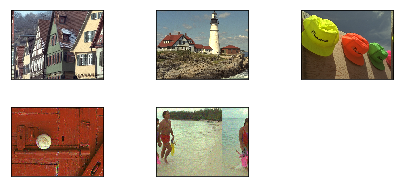

In [29]:
#visualising first 5 data from training dataset

fig = plt.figure()
for i in range(5):
    print(imageDataset[1].shape)
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(imageDataset[i])
    plt.xticks([])
    plt.yticks([])

## Red neuronal CNN

In [30]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="sigmoid")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model



# Custom metric of Determination R2
def coeff_determination(y_true, y_pred):
    SS_res =  k.sum(k.square( y_true-y_pred )) 
    SS_tot = k.sum(k.square( y_true - k.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + k.epsilon()) )

model = create_cnn(img_cols, img_rows, depth, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_squared_error", optimizer='adam', metrics=[coeff_determination])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 384, 512, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 384, 512, 16)      448       
_________________________________________________________________
activation_21 (Activation)   (None, 384, 512, 16)      0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 384, 512, 16)      64        
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 192, 256, 16)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 192, 256, 32)      4640      
_________________________________________________________________
activation_22 (Activation)   (None, 192, 256, 32)      0         
__________

## Entrenamiento del modelo

In [31]:
import time

batch_size = 8
num_epoch = 1

#model training

start = time.time()

model_log = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=6,
                    epochs=num_epoch,
                    verbose=2)

end = time.time()
m = (end - start)/60
m = round(m, 2)
s = (end - start)
s = round(s, 2)

print(f"Training time: {m} min / {s} sec")

Epoch 1/1

 - 198s - loss: 0.0372 - coeff_determination: -5.8703e-01 - val_loss: 0.0301 - val_coeff_determination: -2.1630e-01
Training time: 3.32 min / 199.18 sec
Epoch 1/1

## Evaluación del rendimiento del CNN

In [8]:
#how well did it do? 

start = time.time()

score = model.evaluate_generator(training_generator, verbose=0)

end = time.time()
m = (end - start)/60
m = round(m, 2)
s = (end - start)
s = round(s, 2)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100, '%')

print(f"Test time: {m} min / {s} sec")

Test loss: 0.030368703300020585
Test accuracy: -23.839570463861943 %
Test time: 0.91 min / 54.82 sec


In [9]:
start = time.time()

score = model.evaluate_generator(validation_generator, verbose=0)

end = time.time()
m = (end - start)/60
m = round(m, 2)
s = (end - start)
s = round(s, 2)
print('Train loss:', score[0])
print('Train accuracy:', score[1]*100, '%')

print(f"Train time: {m} min / {s} sec")

Train loss: 0.030041839232193678
Train accuracy: -20.76681180358141 %
Train time: 0.39 min / 23.38 sec


-0.044629667671366224


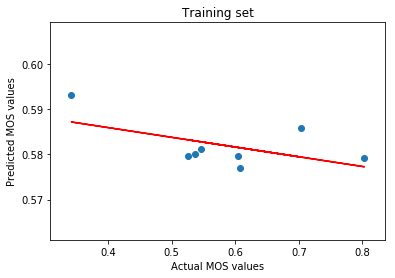

-0.21468391778103957


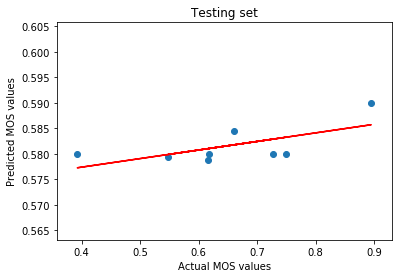

In [15]:
from sklearn.metrics import r2_score

def plot_metric(group, title):
    x_test, y_test = group.__getitem__(0)
    Y_pred = model.predict(x_test)

    r_squared = r2_score(y_test, Y_pred)
    plt.scatter(y_test,Y_pred)
    plt.title(title)
    plt.xlabel('Actual MOS values')
    plt.ylabel('Predicted MOS values')

    denominator = y_test.dot(y_test) - y_test.mean() * y_test.sum()
    m = (y_test.dot(Y_pred) - Y_pred.mean() * y_test.sum()) / denominator
    b = (Y_pred.mean() * y_test.dot(y_test) - y_test.mean() * y_test.dot(Y_pred)) / denominator
    y_poly = m*y_test + b
    plt.plot(y_test, y_poly, 'r')
    #plt.text(1, 0.1, 'R-squared = %0.2f' % r_squared)
    print(r_squared)
    plt.show()
    
plot_metric(training_generator, 'Training set')
plot_metric(validation_generator, 'Testing set')

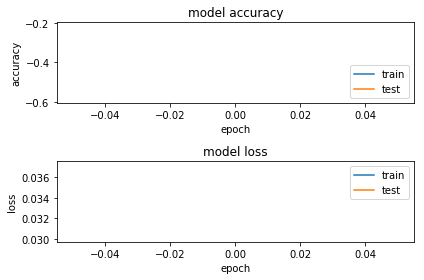

In [32]:
import os
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model_log.history['coeff_determination'])
plt.plot(model_log.history['val_coeff_determination'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("modelCNN.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("modelCNN.h5")
print("Saved model to disk")

In [ ]:
# load json and create model
json_file = open('modelCNN.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("modelCNN.h5")
print("Loaded model from disk")